# Доклад по предмету МСМ
## Тема: Использование библиотек для интерпретации результатов обучения различных  алгоритмов машинного обучения
### Выполнил студент гр. 15КБ(с)РЗПО Петров Алексей
### Преподаватель: Полежаев Петр Никтолаевич



# yellowbrick [документация](https://www.scikit-yb.org/en/latest/quickstart.html)

#### Yellowbrick — это расширение scikit-learn, которое позволяет использовать полезные и красивые визуализации для моделей машинного обучения. Объекты визуализатора и интерфейс ядра — это функции оценки scikit-learn. Если ранее вы работали с данной библиотекой, то рабочий процесс будет вам знаком. Визуализации отображают выбор модели, важность признаков и анализ производительности. Далее небольшие примеры.
pip install yellowbrick
#### Рассмотрим некоторые возможности на примере [датасета распознания вин](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) в scikit-learn. В него входит 13 признаков и 3 целевых класса, которые могут быть загружены напрямую из scikit-learn. В коде ниже датасет импортируется и преобразуется в таблицу данных. Данные могут использоваться в классификаторе без предварительной обработки:

In [219]:
import pandas as pd
from sklearn import datasets
wine_data = datasets.load_wine()
df_wine = pd.DataFrame(wine_data.data,columns=wine_data.feature_names)
df_wine['target'] = pd.Series(wine_data.target)

In [220]:
!# pip install yellowbrick

#### Через scikit-learn можно запустить проверку данных и обучение:

In [221]:
from sklearn.model_selection import train_test_split
X = df_wine.drop(['target'], axis=1)
y = df_wine['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Посмотрим на корреляции между признаками:

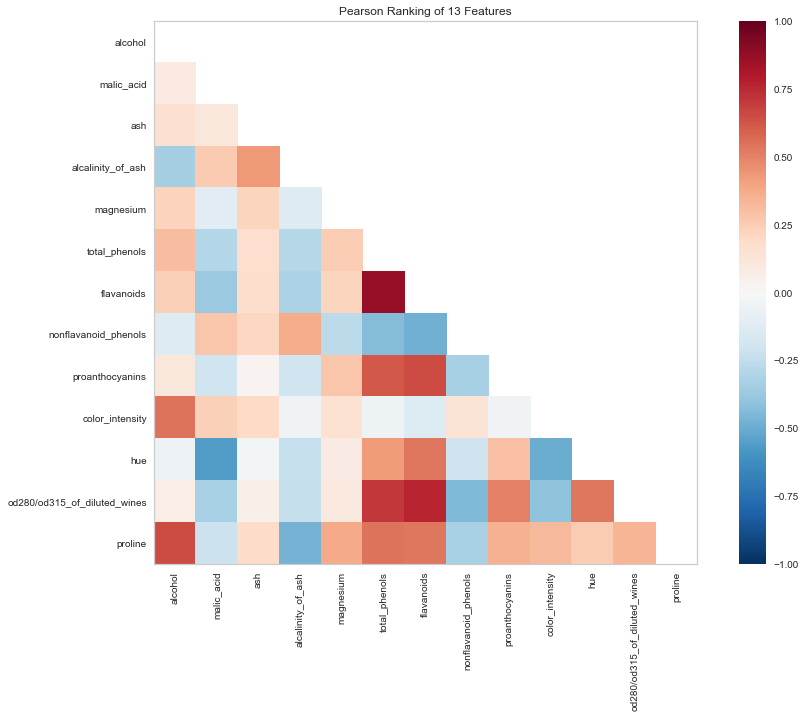

In [222]:
from yellowbrick.features import Rank2D
import matplotlib.pyplot as plt
visualizer = Rank2D(algorithm="pearson",  size=(1080, 720))
visualizer.fit_transform(X_train)
visualizer.poof()

#### Теперь подключим RandomForestClassifier и представим анализ данных в другом визуализаторе:

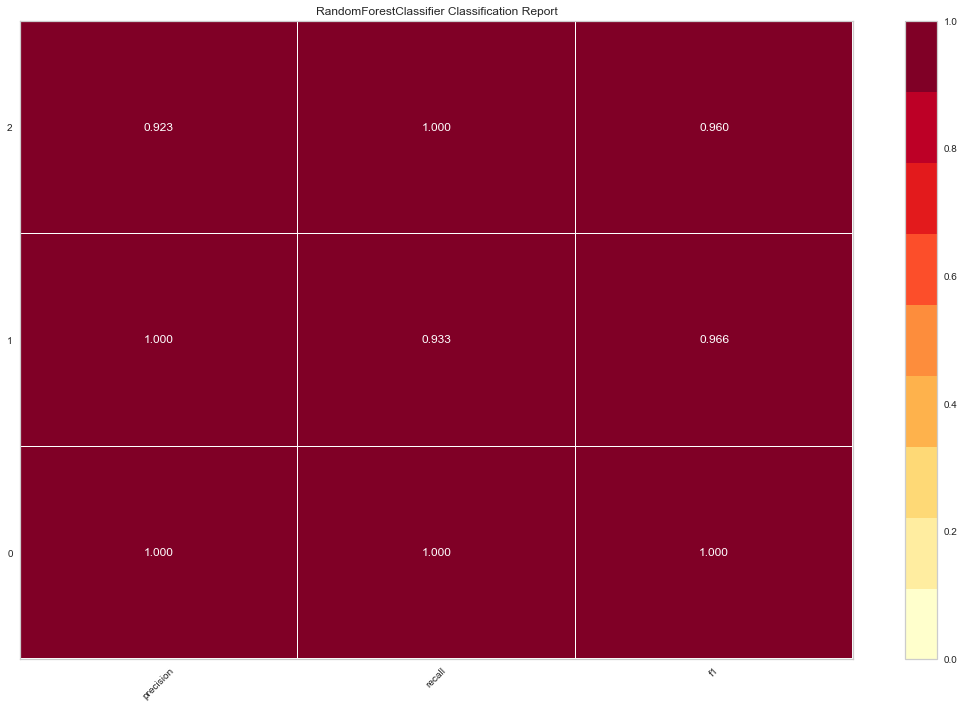

In [223]:
from yellowbrick.classifier import ClassificationReport
from sklearn.ensemble import RandomForestClassifier
model =  RandomForestClassifier()
visualizer = ClassificationReport(model, size=(1080, 720))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

# ELI5 [документация](https://eli5.readthedocs.io/en/latest/) 
#### ELI5 — еще одна визуальная библиотека, удобная для устранения ошибок в моделях и для объяснения прогнозов. Она совместима с самыми популярными Python-библиотеками ML: scikit-learn, XGBoost и Keras. При помощи ELI5 посмотрим на важность признаков нашей модели:

In [224]:
!# pip install eli5

In [225]:
import eli5
eli5.show_weights(model, feature_names = X.columns.tolist())

Weight,Feature
0.1767 ± 0.3908,proline
0.1681 ± 0.3780,color_intensity
0.1454 ± 0.3288,flavanoids
0.1437 ± 0.3552,alcohol
0.0982 ± 0.2455,hue
0.0875 ± 0.2824,od280/od315_of_diluted_wines
0.0602 ± 0.2135,total_phenols
0.0356 ± 0.1378,malic_acid
0.0219 ± 0.1008,proanthocyanins
0.0211 ± 0.0922,alcalinity_of_ash


#### Для определения оснований прогноза можно использовать show_prediction.

In [226]:
from eli5 import show_prediction
show_prediction(model, X_train.iloc[1], feature_names = X.columns.tolist(), 
                show_feature_values=True)

# LIME [документация](https://github.com/marcotcr/lime)
#### LIME (локально интерпретируемое объяснение, не зависящее от устройства модели) — пакет, используемый для интерпретации прогнозов тех или иных алгоритмов машинного обучения. Lime поддерживает объяснения для индивидуальных прогнозов широкого круга классификаторов. Встроена поддержка scikit-learn.


In [227]:
!# pip install lime

#### Будем работать с нашей моделью. Сначала создадим интерпретатор. Он видит набор данных как массив. Имена признаков используются в модели, а имена классов в целевой переменной.

In [228]:
import lime.lime.lime_tabular
explainer = lime.lime.lime_tabular.LimeTabularExplainer(X_train.values,                                            feature_names=X_train.columns.values.tolist(),                                        class_names=y_train.unique())

#### Создадим лямбда-функцию, использующую модель для прогнозирования на основе имеющихся данных:

In [229]:
predict_fn = lambda x: model.predict_proba(x).astype(float)

#### Также используем интерпретатор для расшифровки прогноза. Результат приведён ниже. При помощи Lime можно создать визуализацию, отображающую влияние конкретных признаков на прогноз:

In [230]:
exp = explainer.explain_instance(X_test.values[0], predict_fn, num_features=6)
exp.show_in_notebook(show_all=False)

# MLxtend [документация](http://rasbt.github.io/mlxtend/)
#### Библиотека MLxtend содержит ряд вспомогательных функций для машинного обучения. Например, для StackingClassifier и VotingClassifier, эволюции модели, извлечения признаков, для разработки и для визуализации данных. С помощью MLxtend и сравним границы решения VotingClassifier и входящих в его состав классификаторов:


In [231]:
!# pip install mlxtend

In [232]:
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import itertools 
from sklearn import model_selection

#### Данная визуализация обрабатывает одновременно только два признака, поэтому создадим массив, который будет содержать признаки proline и color_intensity. Они имеют наибольший вес среди всех остальных, как было выяснено в процессе работы с ELI5.

In [233]:
X_train_ml = X_train[['proline', 'color_intensity']].values
y_train_ml = y_train.values

#### Теперь создадим классификаторы и обучим их на тренировочных данных, чтобы получить визуализацию границ решений. Ниже показаны код и его вывод.

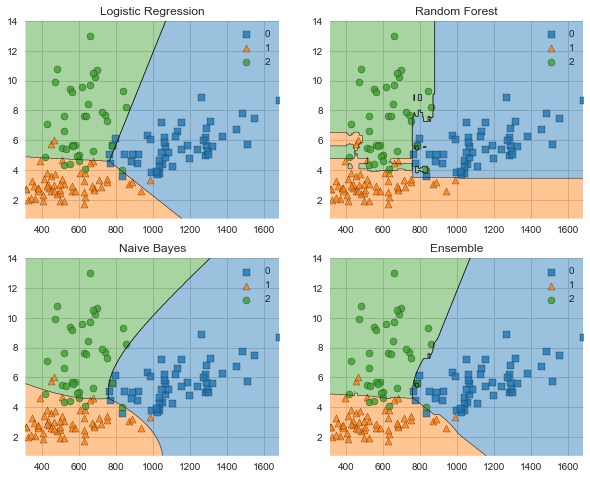

In [234]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1])
value=1.5
width=0.75
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(10,8))
labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Ensemble']
for clf, lab, grd in zip([clf1, clf2, clf3, eclf],
                         labels,
                         itertools.product([0, 1], repeat=2)):
                         
    clf.fit(X_train_ml, y_train_ml)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_ml, y=y_train_ml, clf=clf)
    plt.title(lab)

# Резюме


## YellowBrick  ⭐️2.7k 🍴435 📝 ?
+ Интеграция с Scikit-learn 
+ Интеграция с Matplotlib 
+ Open-Source решение с открытым исходным кодом на Github.
+ Все еще обновляется 
+ нормальная документация 
+ Оценивает стабильность и прогностическую ценность моделей машинного обучения и повысшает скорость экспериментального рабочего процесса 
+ Обеспечивает визуальную интерпретацию поведения модели в многомерном пространстве объектов. 
+ Предоставляет визуальные инструменты для мониторинга производительности моделей в реальных приложениях. 

## ELI5 ⭐️2K 🍴272 📝483
+ Интеграция с scikit-learn 
    В настоящее время ELI5 позволяет объяснять веса и прогнозы линейных классификаторов и регрессоров scikit-learn, распечатывать деревья решений в виде текста или SVG, показывать важность функций и объяснять предсказания деревьев решений и ансамблей на основе деревьев. 
    Pipeline и FeatureUnion поддерживаются. 
    ELI5 понимает утилиты обработки текста из scikit-learn и может соответствующим образом выделять текстовые данные. Он также позволяет отлаживать хеширование для отладки конвейеров scikit-learn, которые содержат HashingVectorizer. 

+ Интеграция с  XGBoost 
Показывает важность функций и объясняет прогнозы XGBClassifier, XGBRegressor и xgboost.Booster. 

+ Интеграция с  LightGBM 
Показывает важность функций и объясняет прогнозы LGBMClassifier и LGBMRegressor. 

+ Интеграция с  CatBoost 
Показывает особенности функций CatBoostClassifier и CatBoostRegressor. 

+ Интеграция с  lightning 
Объясняет вес и прогнозы lightning  классификаторов и регрессоров. 

+ Интеграция с  sklearn-crfsuite 
ELI5 позволяет проверять вес моделей sklearn_crfsuite.CRF. 

+ Интеграция с  Keras 
Объясняет предсказания классификаторов изображений с помощью визуализации Grad-CAM. 

+ Интеграция с  Lime 
    ELI5 также реализует несколько алгоритмов для проверки моделей черного ящика (см. Проверка оценщиков черного ящика ): 
    TextExplainer позволяет объяснять предсказания любого текстового классификатора, используяалгоритм LIME (Рибейро и др., 2016). Существуют утилиты для использования LIME с нетекстовыми данными и произвольными классификаторами черного ящика, но эта функция в настоящее время является экспериментальной. 
    Метод перестановки важности может быть использован для вычисления значений характеристик для оценок черного ящика.

## LIME ⭐️7.5k 🍴1.2k 📝587
+ Объясняет предсказания любого классификатора МЛ 
+ Этот проект посвящен объяснению того, что делают классификаторы (или модели) машинного обучения. В настоящее время  поддерживает объяснение отдельных предсказаний для текстовых классификаторов или классификаторов, которые действуют на таблицы (массивы числовых или категориальных данных) или изображений, с помощью пакета, называемого lime. 
+ Лайм может объяснить любой классификатор черного ящика с двумя или более классами. Все, что требуется, это то, что классификатор реализует функцию, которая принимает необработанный текст или массив с нулевыми значениями и выводит вероятность для каждого класса. Поддержка классификаторов scikit-learn встроена. 

- не ставится через PIP, нужно клонировать с гитхаба и в файлах добавлять пути к пакету lime  


## MLxtend ⭐️2.9k 🍴637 📝1.1k
+ можно установить через Conda и Pip 
+ Хорошая визуализация данных 